# Oscillation in eeg 

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
import scipy as sp
import numpy as np 


import mne 

warnings.filterwarnings('ignore')

Pas µV mais des mV 

Sampling rate = 250 Hz 

Filtre harr wavelet filter 

cut le sigal en plusieurs petites parties => 2 avant le gap 

durée totale aproximativement 1h30

In [8]:
sampling_rate = 250 # in seconds
time = 1/sampling_rate
unit_time = 's'

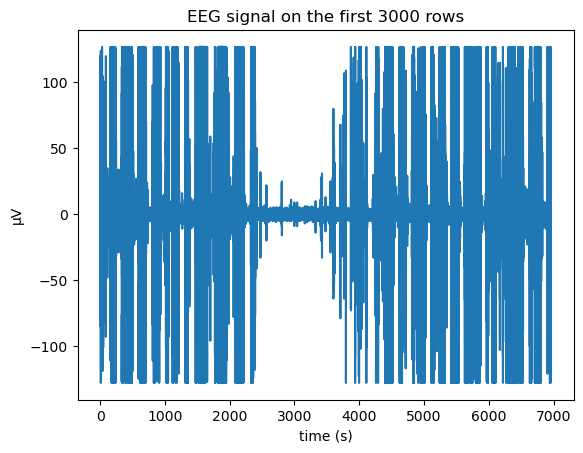

In [9]:
df = pd.read_csv('../data/EEGArchi13mPFC.txt')
# df = df.iloc[int(start*20_000):int(end*20_000)] 
df['time'] = df.index * time
df.rename(columns={'0': 'µV'}, inplace=True)
plt.plot(df['time'], df['µV'])
plt.xlabel(f'time ({unit_time})')
plt.ylabel('µV')
plt.title('EEG signal on the first 3000 rows')
plt.savefig("./figures/EEG_signal_all_data.png")
plt.show()

## 1 Plot on the first part of the experiment (before the gap)

In [26]:
def four_s_cutting(path = '../data/EEGArchi13mPFC.txt') : 
    df = pd.read_csv(path)
    df['time'] = df.index * time
    df.rename(columns={'0': 'mV'}, inplace=True)
    df = df.iloc[int(0*sampling_rate):int(2000*sampling_rate)]
    res = []
    for i in range(0,len(df),1000) :
        try : 
            df_red = df.iloc[i:i+1000]
        except : 
            df_red = df.iloc[i:]

        res.append(df_red)
    return res

### 1.2 Plot with mne 

Creating RawArray with float64 data, n_channels=500, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


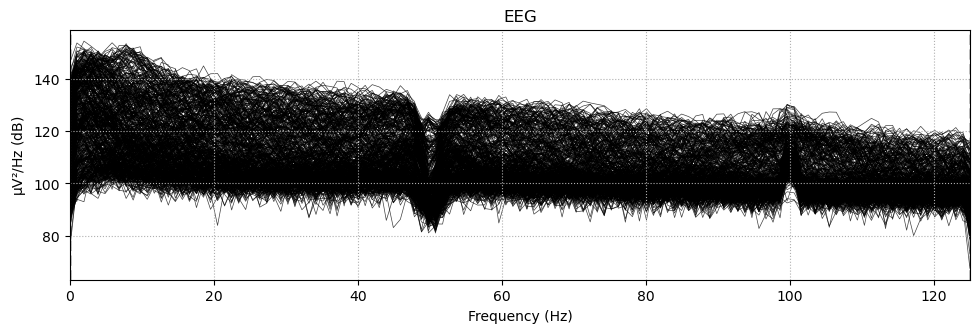

In [48]:
data_cut = four_s_cutting()
data = np.array([data_cut[i]["mV"] for i in range(len(data_cut))]) ## All the data
# data = np.array([data_cut[i]["mV"] for i in range(50)])
info = mne.create_info(ch_names=['eeg']*500,
                       ch_types=['eeg']*500,
                       sfreq=sampling_rate)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot_psd()

## 2. Filtering 

## 3. Heatmap

Effective window size : 4.000 (s)


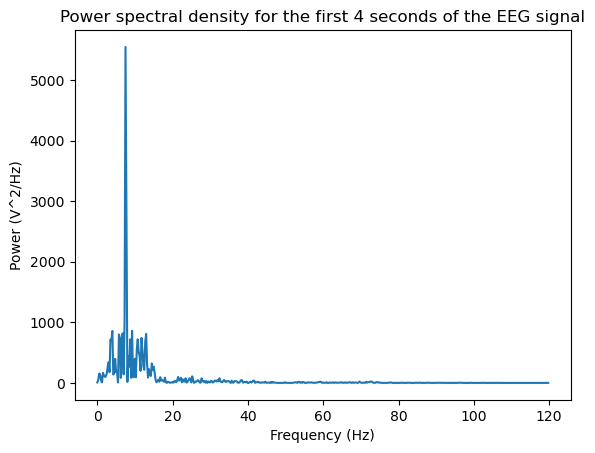

In [98]:
plt.close('all')
frequencies = np.arange(0, 120, 0.2495)
power = mne.time_frequency.psd_welch(
    simulated_raw, 
    fmin=0, 
    fmax=120,
    n_fft=1000, 
    n_overlap=0, 
    n_per_seg=1000,
    n_jobs=1, 
    verbose=None
    )

plt.plot(frequencies, power[0][462], label='PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.title('Power spectral density for the first 4 seconds of the EEG signal')
plt.savefig("./figures/PSD.png")
plt.show()

reconstruct dataframe 

time| 4 | 8 
---|---|---
freq |   power |  power
...  |   ...    | ...

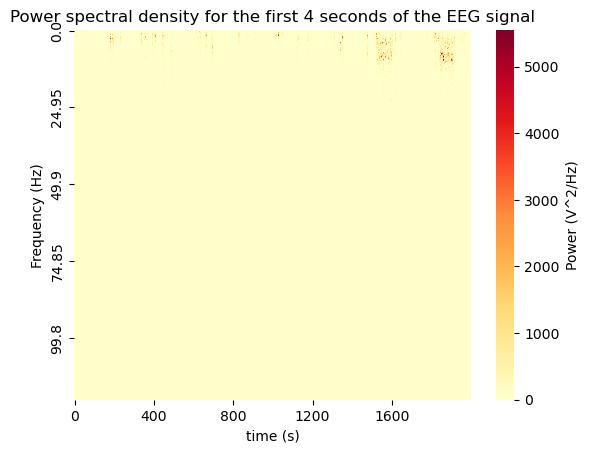

In [108]:
plt.close('all')
htmap = pd.DataFrame(power[0])
htmap = htmap.T
htmap["freq"] = frequencies
htmap = htmap.set_index("freq", drop=True)
# htmap = htmap.iloc[:100]
htmap = htmap.rename(columns=dict((i,i*4) for i in range(500)))
sns.heatmap(htmap, cmap="YlOrRd", xticklabels=100, yticklabels=100, cbar_kws={'label': 'Power (V^2/Hz)'})
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Power spectral density for the first 4 seconds of the EEG signal')
plt.show()

Strange because we get only theta waves 

Should we apply a max value for the PSD ? bc 5000 is very huge